## DEX US EU

In [100]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from random_walk_model import (
    discretise_Wt,
    simulate_multiple_discrete_paths,
    forecast_from_multiple_paths,
    plot_multiple_paths_vs_history
)
from arima_model import (
    simulate_paths_and_plot,
    evaluate_simulations
)
from rmse import (
    evaluate_rmse_mae_per_path
)
from utils_summary import (
    pack_metrics,
    append_result,
    finalize_summary
)


# Read the CSV file from the preprocessing folder
train_df = pd.read_csv('../2. preprocesing/train_df_dexuseu.csv', index_col=0, parse_dates=True)

# Show the first rows
train_df.head()


rate  rate_interpolated  log_rate      diff        Wt
date                                                               
2015-01-05  1.1918             1.1918  0.175465 -0.008106 -0.008049
2015-01-06  1.1936             1.1936  0.176974  0.001509  0.001566
2015-01-07  1.1820             1.1820  0.167208 -0.009766 -0.009709
2015-01-08  1.1811             1.1811  0.166446 -0.000762 -0.000705
2015-01-09  1.1830             1.1830  0.168054  0.001607  0.001665

### Random Walk

In [102]:
# model:
# X_t - X_{t-1} = mu + W_t

# X_t = X_0 + mu*t + sum(W_t)

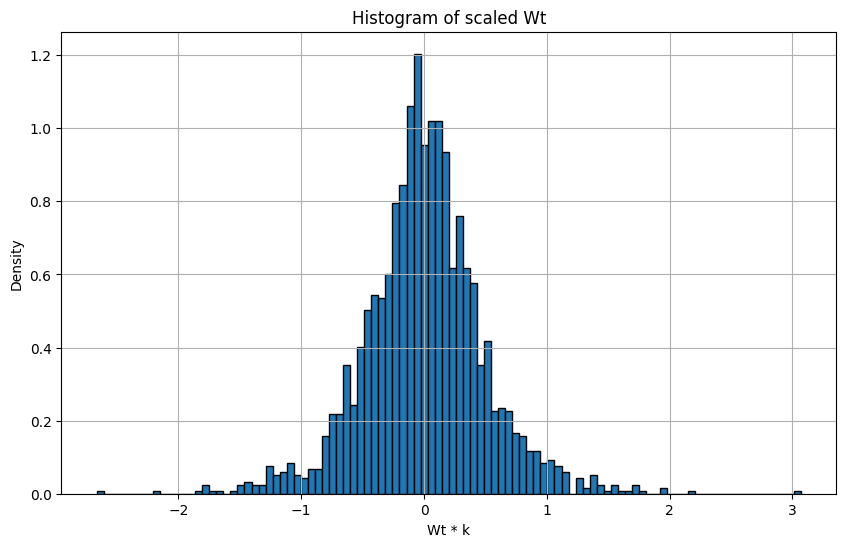

count    2085.000000
mean        0.000001
std         0.004929
min        -0.026667
25%        -0.002622
50%        -0.000034
75%         0.002716
max         0.030700
Name: Wt, dtype: float64


In [103]:
k = 100
df= train_df.copy()
df['scaled_Wt'] = df['Wt'] * k
# basic histogram of the scaled Wt
plt.figure(figsize=(10,6))
plt.hist(df['scaled_Wt'], bins=100, edgecolor='black', density=True)
plt.title('Histogram of scaled Wt')
plt.xlabel('Wt * k')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# statistics of the original Wt
print(df['Wt'].describe())

Empirical probabilities:
P(-1) = 0.1247, P(0) = 0.7535, P(+1) = 0.1218


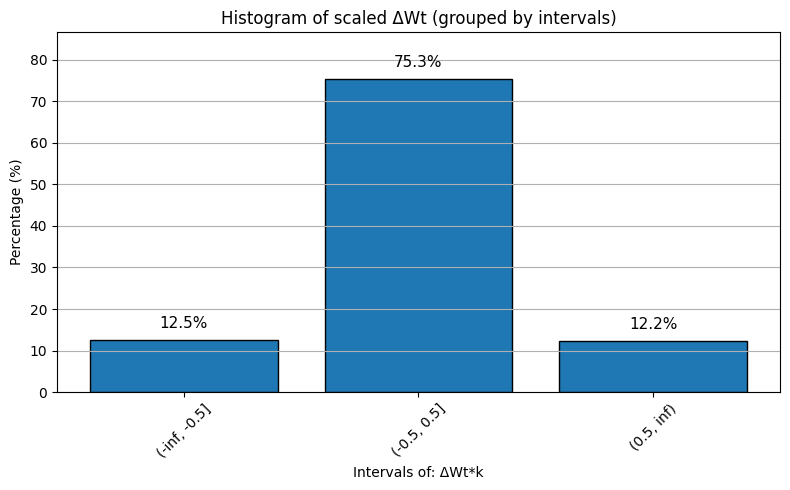

rate  rate_interpolated  log_rate      diff        Wt  \
date                                                                  
2015-01-05  1.1918            1.19180  0.175465 -0.008106 -0.008049   
2015-01-06  1.1936            1.19360  0.176974  0.001509  0.001566   
2015-01-07  1.1820            1.18200  0.167208 -0.009766 -0.009709   
2015-01-08  1.1811            1.18110  0.166446 -0.000762 -0.000705   
2015-01-09  1.1830            1.18300  0.168054  0.001607  0.001665   
...            ...                ...       ...       ...       ...   
2022-12-26     NaN            1.06375  0.061800  0.001552  0.001610   
2022-12-27  1.0654            1.06540  0.063350  0.001550  0.001607   
2022-12-28  1.0622            1.06220  0.060342 -0.003008 -0.002951   
2022-12-29  1.0668            1.06680  0.064664  0.004321  0.004378   
2022-12-30  1.0698            1.06980  0.067472  0.002808  0.002865   

            scaled_Wt  e_t scaled_Wt_bin  
date                                      
2015-01-05  -0.804883   -1  (-inf, -0.5]  
2015-01-06   0.156636    0   (-0.5, 0.5]  
2015-01-07  -0.970885   -1  (-inf, -0.5]  
2015-01-08  -0.070453    0   (-0.5, 0.5]  
2015-01-09   0.166456    0   (-0.5, 0.5]  
...               ...  ...           ...  
2022-12-26   0.160950    0   (-0.5, 0.5]  
2022-12-27   0.160710    0   (-0.5, 0.5]  
2022-12-28  -0.295090    0   (-0.5, 0.5]  
2022-12-29   0.437847    0   (-0.5, 0.5]  
2022-12-30   0.286538    0   (-0.5, 0.5]  

[2085 rows x 8 columns]

In [104]:
# ----------------------------------------
# with DEXUSEU training data
# ----------------------------------------

# Read the CSV file from the preprocessing folder
train_df = pd.read_csv('../2. preprocesing/train_df_dexuseu.csv', index_col=0, parse_dates=True)
# Step 1: Discretise Wt and get probabilities
k=100
train_df_dexuseu, p_dict = discretise_Wt(train_df, k=k)

train_df_dexuseu


In [105]:
# Manual assigning of probabilities for the example
# p_dict = {-1: 0.27055, 0: 0.4589, 1: 0.27055}
p_dict = {-1: 0.13, 0: 0.74, 1: 0.13}

# trend estimation (preproccessing)
estimated_mu = -0.000004  # this must be your actual drift!
estimated_mu = -0.000057  # this with the new method = df['log_rate'].diff().mean()

# df for testing
df_test = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)

#### Forecasting

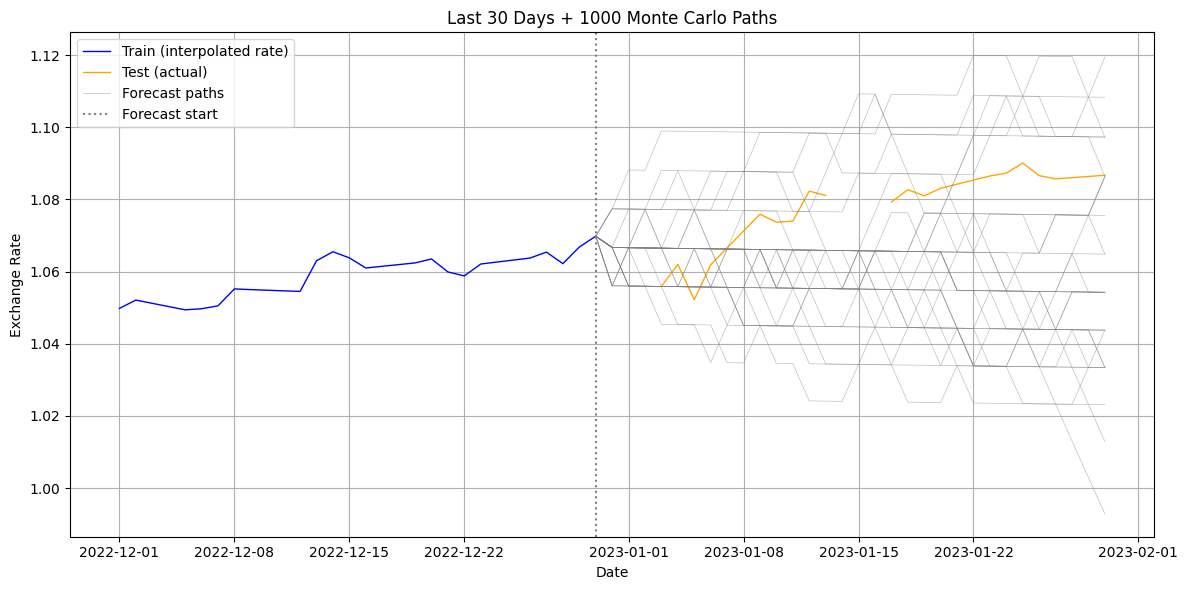

Expected RMSE (Monte Carlo): 0.024741
Expected MAE  (Monte Carlo): 0.021608


model horizon  expected_rmse  expected_mae
0  RandomWalk      1M       0.024741      0.021608

In [106]:
# RW for 1 month

# Step 2: Simulate discrete random walk paths
paths = simulate_multiple_discrete_paths(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon=31,      # simulate 1 month
    n_paths=1000,
    seed=42
)
# step 3: Forecast from multiple paths
df_paths = forecast_from_multiple_paths(
    train_df=train_df_dexuseu, # historical data
    paths=paths,    # the simulated paths
    k=k,            # the same K value
    mu=estimated_mu # this must be your actual drift!
)

# Plot the paths against the historical data
plot_multiple_paths_vs_history(
    train_df=train_df_dexuseu,
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate',
    n_show=30
)

# Evaluation for 1 month
df_paths.index.name = 'path_number'
df_test = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)
df_paths.columns = pd.to_datetime(df_paths.columns)   # Convert column names to datetime

rmse_values, expected_rmse, mae_values, expected_mae = evaluate_rmse_mae_per_path(
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate'
)

print(f"Expected RMSE (Monte Carlo): {expected_rmse:.6f}")
print(f"Expected MAE  (Monte Carlo): {expected_mae:.6f}")

# Prepare the summary metrics
summary = pd.DataFrame()
metrics_rw = {
    "expected_rmse": float(expected_rmse),
    "expected_mae": float(expected_mae),
}
summary = append_result(summary, metrics_rw, model_name="RandomWalk", horizon="1M")
summary


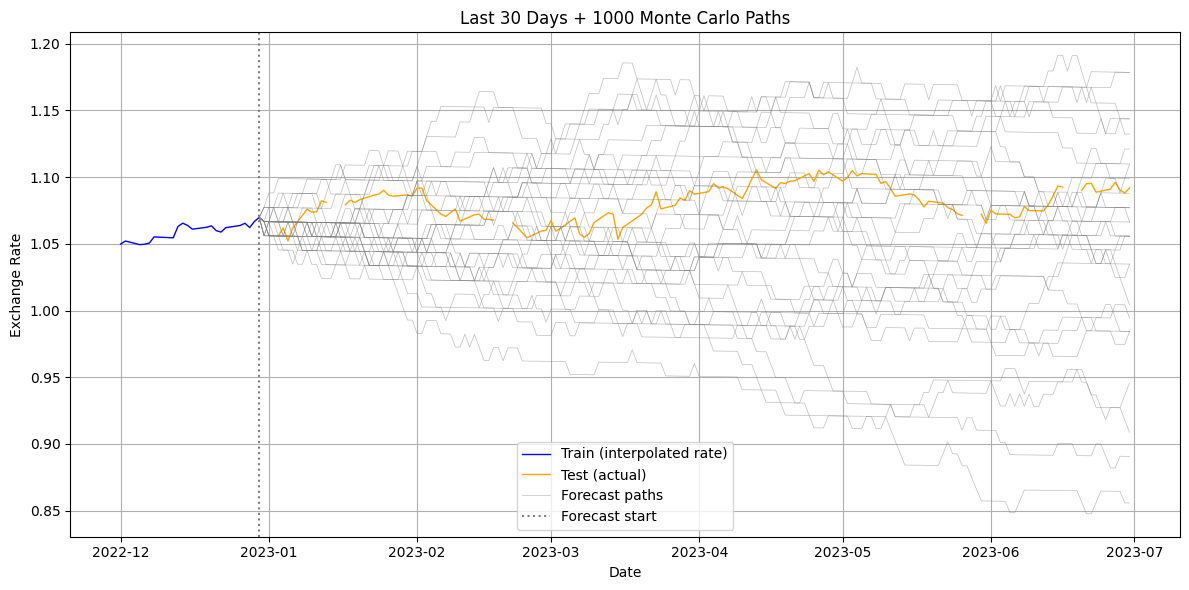

Expected RMSE (Monte Carlo): 0.050992
Expected MAE  (Monte Carlo): 0.043836


model horizon  expected_rmse  expected_mae
0  RandomWalk      1M       0.024741      0.021608
1  RandomWalk      6M       0.050992      0.043836

In [107]:
# RW for 6 month

# Step 2: Simulate discrete random walk paths
paths = simulate_multiple_discrete_paths(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon= 182,      # simulate 6 month
    n_paths=1000,
    seed=42
)
# step 3: Forecast from multiple paths
df_paths = forecast_from_multiple_paths(
    train_df=train_df_dexuseu, # historical data
    paths=paths,    # the simulated paths
    k=k,            # the same K value
    mu=estimated_mu # this must be your actual drift!
)

# Plot the paths against the historical data
plot_multiple_paths_vs_history(
    train_df=train_df_dexuseu,
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate',
    n_show=30
)

# Evaluation for 6 month
df_test = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)
df_paths.index.name = 'path_number'
df_paths.columns = pd.to_datetime(df_paths.columns)   # Convert column names to datetime

rmse_values, expected_rmse, mae_values, expected_mae = evaluate_rmse_mae_per_path(
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate'
)

print(f"Expected RMSE (Monte Carlo): {expected_rmse:.6f}")
print(f"Expected MAE  (Monte Carlo): {expected_mae:.6f}")

# Prepare the summary metrics

metrics_rw = {
    "expected_rmse": float(expected_rmse),
    "expected_mae": float(expected_mae),
}
summary = append_result(summary, metrics_rw, model_name="RandomWalk", horizon="6M")
summary


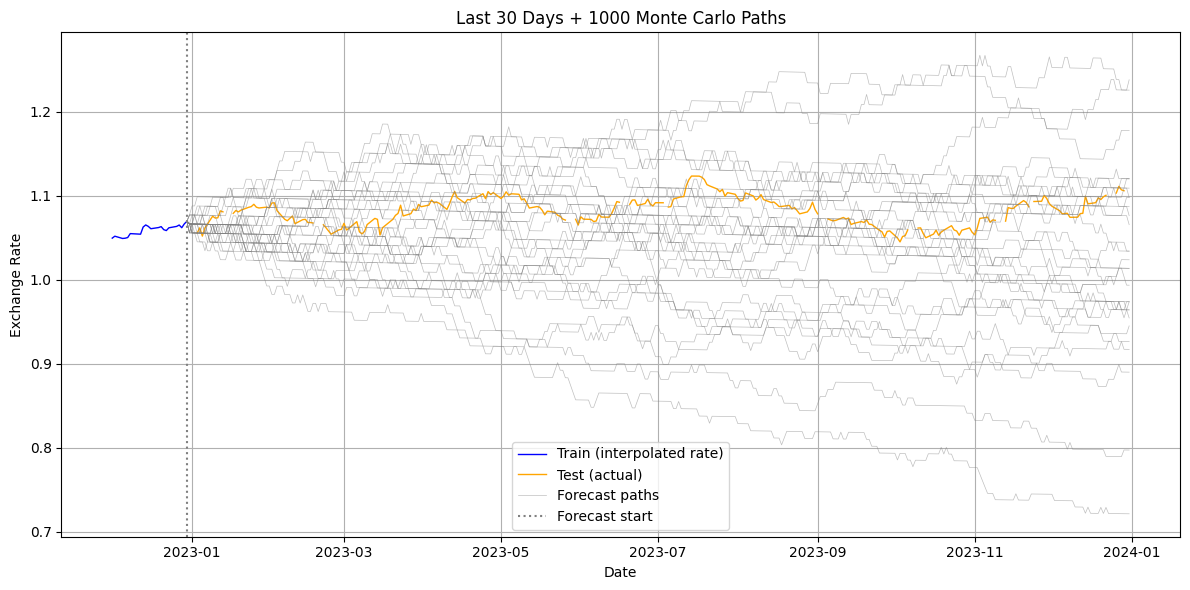

Expected RMSE (Monte Carlo): 0.070192
Expected MAE  (Monte Carlo): 0.060127


model horizon  expected_rmse  expected_mae
0  RandomWalk      1M       0.024741      0.021608
1  RandomWalk      6M       0.050992      0.043836
2  RandomWalk     12M       0.070192      0.060127

In [108]:
# RW for 12 month

# Step 2: Simulate discrete random walk paths
paths = simulate_multiple_discrete_paths(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon=366,      # simulate 6 month
    n_paths=1000,
    seed=42
)
# step 3: Forecast from multiple paths
df_paths = forecast_from_multiple_paths(
    train_df=train_df_dexuseu, # historical data
    paths=paths,    # the simulated paths
    k=k,            # the same K value
    mu=estimated_mu # this must be your actual drift!
)

# Plot the paths against the historical data
plot_multiple_paths_vs_history(
    train_df=train_df_dexuseu,
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate',
    n_show=30
)

# Evaluation for 12 month
df_test = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)
df_paths.index.name = 'path_number'
df_paths.columns = pd.to_datetime(df_paths.columns)   # Convert column names to datetime

rmse_values, expected_rmse, mae_values, expected_mae = evaluate_rmse_mae_per_path(
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate'
)

print(f"Expected RMSE (Monte Carlo): {expected_rmse:.6f}")
print(f"Expected MAE  (Monte Carlo): {expected_mae:.6f}")

# Prepare the summary metrics
metrics_rw = {
    "expected_rmse": float(expected_rmse),
    "expected_mae": float(expected_mae),
}
summary = append_result(summary, metrics_rw, model_name="RandomWalk", horizon="12M")
summary

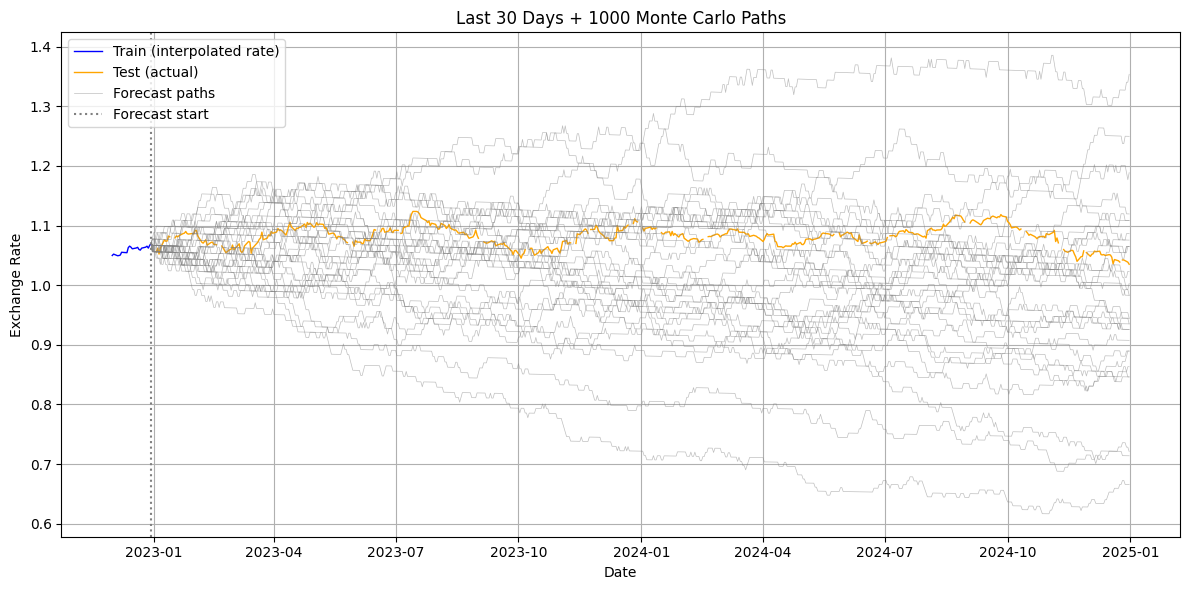

Expected RMSE (Monte Carlo): 0.096621
Expected MAE  (Monte Carlo): 0.083075


model horizon  expected_rmse  expected_mae
0  RandomWalk      1M       0.024741      0.021608
1  RandomWalk      6M       0.050992      0.043836
2  RandomWalk     12M       0.070192      0.060127
3  RandomWalk     24M       0.096621      0.083075

In [109]:
# RW for 2 years

# Step 2: Simulate discrete random walk 
paths = simulate_multiple_discrete_paths(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon=366*2,      # simulate 2 years
    n_paths=1000,
    seed=42
)
# step 3: Forecast from multiple paths
df_paths = forecast_from_multiple_paths(
    train_df=train_df_dexuseu, # historical data
    paths=paths,    # the simulated paths
    k=k,            # the same K value
    mu=estimated_mu # this must be your actual drift!
)

# Plot the paths against the historical data
plot_multiple_paths_vs_history(
    train_df=train_df_dexuseu,
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate',
    n_show=30
)

# Evaluation for 2 years
df_test = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)
df_paths.index.name = 'path_number'
df_paths.columns = pd.to_datetime(df_paths.columns)   # Convert column names to datetime

rmse_values, expected_rmse, mae_values, expected_mae = evaluate_rmse_mae_per_path(
    df_paths=df_paths,
    df_test=df_test,
    rate_col='rate'
)

print(f"Expected RMSE (Monte Carlo): {expected_rmse:.6f}")
print(f"Expected MAE  (Monte Carlo): {expected_mae:.6f}")

# Prepare the summary metrics
metrics_rw = {
    "expected_rmse": float(expected_rmse),
    "expected_mae": float(expected_mae),
}
summary = append_result(summary, metrics_rw, model_name="RandomWalk", horizon="24M")
summary

### ARIMA model

In [110]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# train_df is already loaded with index as date
series = train_df['log_rate'] # X_t = log(rate_t)

# model: X_t' = 
#           phi_1 * X_{t-1}' - phi_2 * X_{t-2}' - ... - phi_p * X_{t-p}' 
#           + mu 
#           + e_t + theta_1 * e_{t-1} + theta_2 * e_{t-2} + ... + theta_q * e_{t-q}




In [111]:
# DETERMINE d (differencing order) using ADF and KPSS tests
# from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

# Direct ADF test  Augmented Dickey-Fuller already done in preprocessing
adf_res = adfuller(train_df['log_rate'])
print("ADF p-value:", adf_res[1])

ADF p-value: 0.12271024894831561


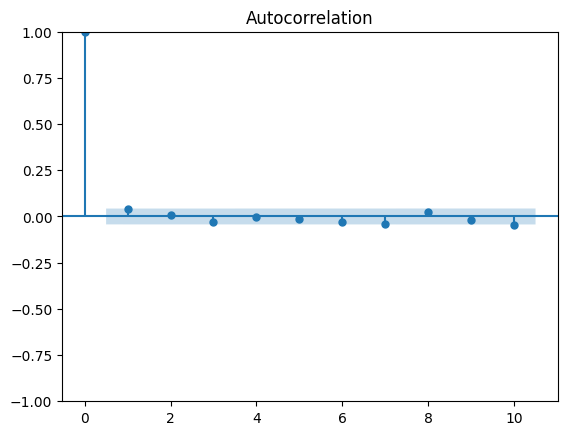

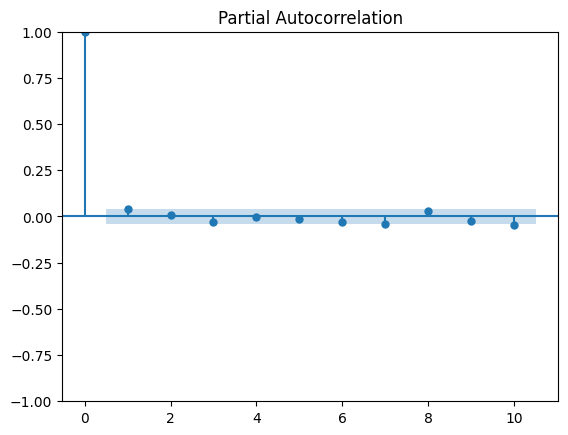

In [112]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# diff_series = train_df['log_rate'].diff().dropna()
diff_series = train_df['Wt'].dropna()

# selct q: with ACF autocorrelation function
plot_acf(diff_series, lags=10)
plt.show()

# for select p with PACF partial autocorrelation function
plot_pacf(diff_series, lags=10)
plt.show()

In [113]:
# Using auto arima to selct p and q
import pmdarima as pm

auto_model = pm.auto_arima(train_df['log_rate'],
                           start_p=0, max_p=5,
                           start_q=0, max_q=5,
                           d=1, seasonal=False, trace=True,
                           error_action='ignore', suppress_warnings=True,
                           with_intercept=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16227.269, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16229.198, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16229.144, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16229.038, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-16227.233, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16227.212, Time=0.50 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16221.266, Time=0.87 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-16230.987, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-16229.026, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-16229.003, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-16230.934, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-16227.024, Time=0.40 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 4.870 seconds
                               SARIMAX Results                  

In [114]:
# model ARIMA(1,1,0) without intercept: 
#       X_t' = 
#           phi_1 * X_{t-1}' 
#           + e_t
#
#  X_t' = 0.0435 * X_{t-1}' + N(0, sigma2 = 2.422e-05)
#  
#  X_t' = X_t - X_{t-1}

In [115]:
# 1) Get the selected (p,d,q) and whether an intercept was used
order = auto_model.order                       # e.g., (1, 1, 0)
trend = 'c' if auto_model.with_intercept else 'n'  # 'c' => includes drift (intercept)

# 2) Refit on your training log series with statsmodels
sm_model = ARIMA(train_df['log_rate'], order=order, trend=trend)
res = sm_model.fit()

In [116]:
# Load test data
test_df = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv', index_col='date', parse_dates=True)

#### Forecasting ARIMA

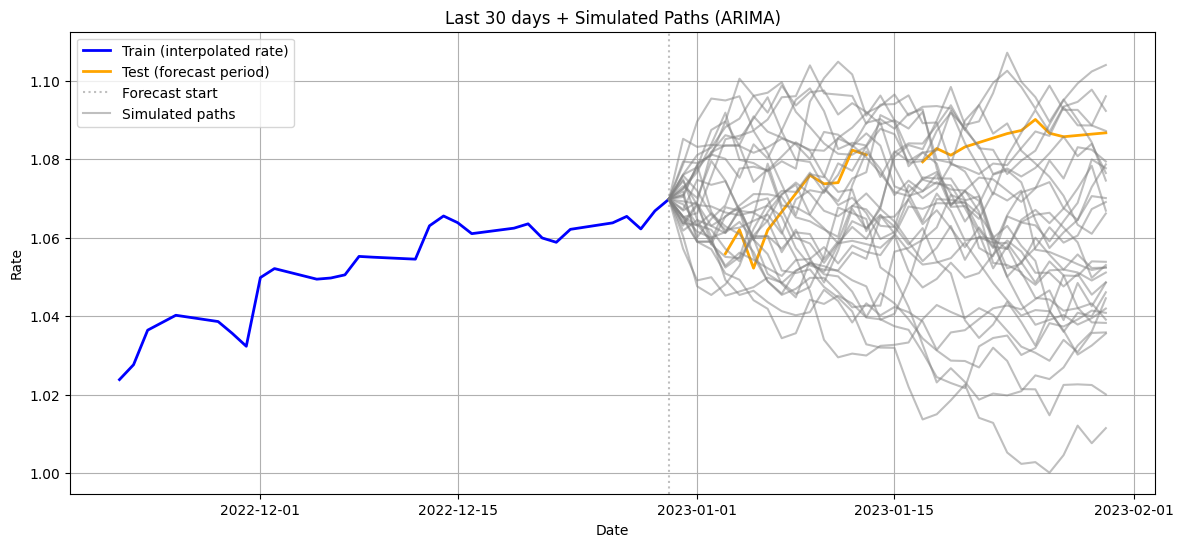

Evaluated dates: 19
Evaluated paths: 1000 of 1000
✅ Expected RMSE: 0.022938
✅ Expected MAE: 0.019976


In [117]:
# ARIMA Forecasting and Evaluation 31 DAYS

# 1) Simulate paths and plot
all_paths = simulate_paths_and_plot(res, train_df, 
                                    test_df, steps=31, 
                                    n_sims=1000,
                                    n_show=30, 
                                    rate_col='rate_interpolated',
                                    base_seed=42
                                    )
# 2) Evaluate simulations
metrics_arima = evaluate_simulations(all_paths, test_df, rate_col='rate')

# Prepare the summary metrics
summary = append_result(
    summary_df=summary,
    metrics={
        "expected_rmse": metrics_arima["expected_rmse"],
        "expected_mae":  metrics_arima["expected_mae"]
    },
    model_name="ARIMA",
    horizon="1M"
)


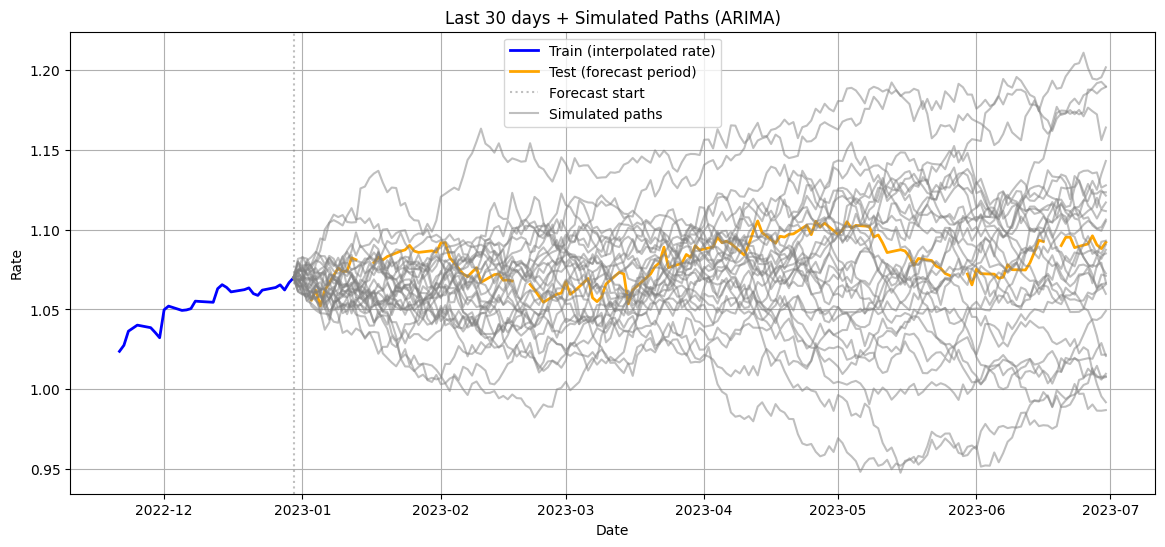

Evaluated dates: 125
Evaluated paths: 1000 of 1000
✅ Expected RMSE: 0.050245
✅ Expected MAE: 0.043076


In [118]:
# ARIMA Forecasting and Evaluation 6 months

# 1) Simulate paths and plot
all_paths = simulate_paths_and_plot(res, train_df, 
                                    test_df, steps=182, 
                                    n_sims=1000,
                                    n_show=30, 
                                    rate_col='rate_interpolated',
                                    base_seed=42
                                    )
# 2) Evaluate simulations
metrics_arima = evaluate_simulations(all_paths, test_df, rate_col='rate')
# Prepare the summary metrics
summary = append_result(
    summary_df=summary,
    metrics={
        "expected_rmse": metrics_arima["expected_rmse"],
        "expected_mae":  metrics_arima["expected_mae"]
    },
    model_name="ARIMA",
    horizon="6M"
)


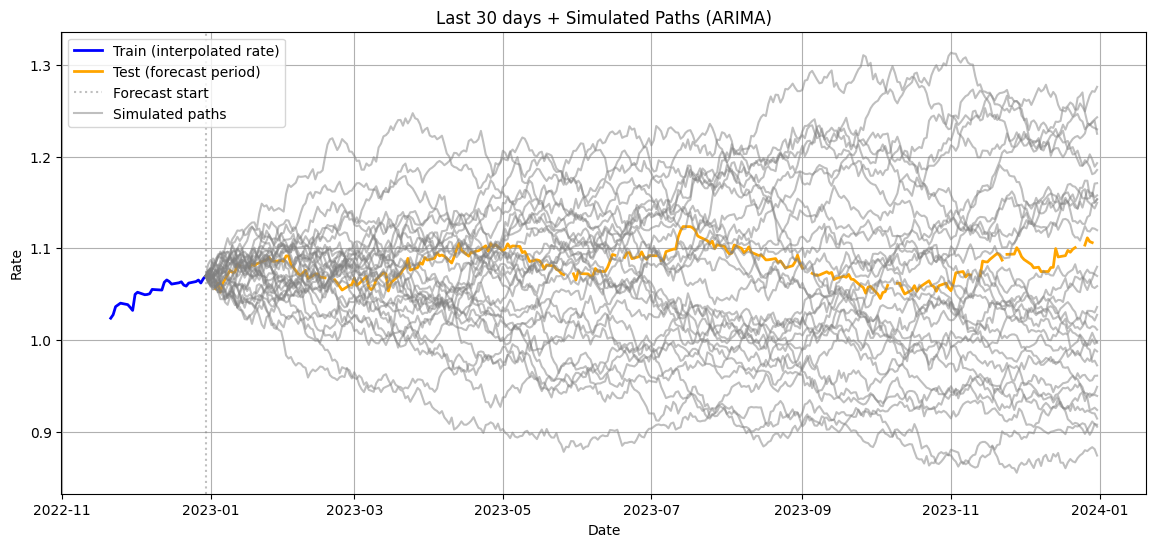

Evaluated dates: 249
Evaluated paths: 1000 of 1000
✅ Expected RMSE: 0.068930
✅ Expected MAE: 0.058591


In [119]:
# ARIMA Forecasting and Evaluation 12 months

# 1) Simulate paths and plot
all_paths = simulate_paths_and_plot(res, train_df, 
                                    test_df, steps=366, 
                                    n_sims=1000,
                                    n_show=30, 
                                    rate_col='rate_interpolated',
                                    base_seed=42
                                    )
# 2) Evaluate simulations
metrics_arima = evaluate_simulations(all_paths, test_df, rate_col='rate')
# Prepare the summary metrics
summary = append_result(
    summary_df=summary,
    metrics={
        "expected_rmse": metrics_arima["expected_rmse"],
        "expected_mae":  metrics_arima["expected_mae"]
    },
    model_name="ARIMA",
    horizon="12M"
)

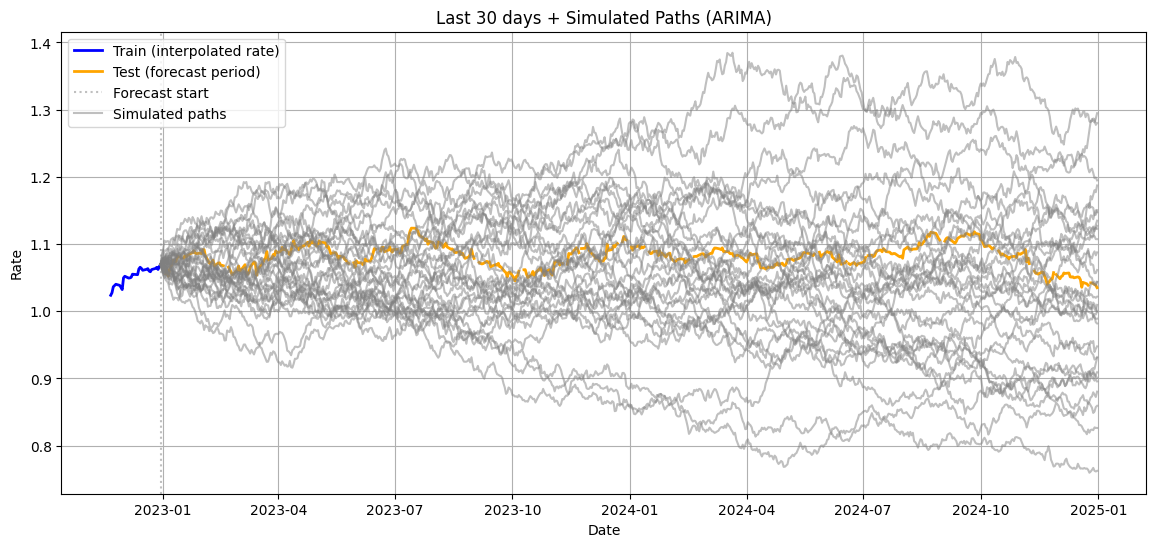

Evaluated dates: 500
Evaluated paths: 1000 of 1000
✅ Expected RMSE: 0.094618
✅ Expected MAE: 0.080216


model horizon  expected_rmse  expected_mae
0  RandomWalk      1M       0.024741      0.021608
1  RandomWalk      6M       0.050992      0.043836
2  RandomWalk     12M       0.070192      0.060127
3  RandomWalk     24M       0.096621      0.083075
4       ARIMA      1M       0.022938      0.019976
5       ARIMA      6M       0.050245      0.043076
6       ARIMA     12M       0.068930      0.058591
7       ARIMA     24M       0.094618      0.080216

In [120]:
# ARIMA Forecasting and Evaluation 2 years

# 1) Simulate paths and plot
all_paths = simulate_paths_and_plot(res, train_df, 
                                    test_df, steps=366*2, 
                                    n_sims=1000,
                                    n_show=30, 
                                    rate_col='rate_interpolated',
                                    base_seed=42
                                    )
# 2) Evaluate simulations
metrics_arima = evaluate_simulations(all_paths, test_df, rate_col='rate')
# Prepare the summary metrics
summary = append_result(
    summary_df=summary,
    metrics={
        "expected_rmse": metrics_arima["expected_rmse"],
        "expected_mae":  metrics_arima["expected_mae"]
    },
    model_name="ARIMA",
    horizon="24M"
)
summary

In [121]:
# lower than RW, ARIMA is better than RW for 1 month, 6 , 12, 24 month ahead forecasts

### Structural Model + AR(1)

In [122]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# ------------------------
# 1) Load data
# ------------------------
train_df = pd.read_csv('../2. preprocesing/train_df_dexuseu.csv', parse_dates=True, index_col=0).sort_index()
test_df  = pd.read_csv('../2. preprocesing/test_df_dexuseu.csv',  parse_dates=True, index_col='date').sort_index()

m1_eu  = pd.read_csv('../2. preprocesing/M1_EU_daily.csv',                 parse_dates=True, index_col=0).sort_index()
m1_us  = pd.read_csv('../2. preprocesing/M1_USA_daily.csv',                parse_dates=True, index_col=0).sort_index()
r3m_eu = pd.read_csv('../2. preprocesing/interest_rate_3m_EU_daily.csv',   parse_dates=True, index_col=0).sort_index()
r3m_us = pd.read_csv('../2. preprocesing/interest_rate_3m_USA_daily.csv',  parse_dates=True, index_col=0).sort_index()
ip_eu  = pd.read_csv('../2. preprocesing/INDPRO_EU_daily.csv',             parse_dates=True, index_col=0).sort_index()
ip_us  = pd.read_csv('../2. preprocesing/INDPRO_USA_daily.csv',            parse_dates=True, index_col=0).sort_index()

# Ensure expected column names (robust to unknown original headers)
def set_single_col(df, name):
    if df.shape[1] != 1:
        raise ValueError(f"Expected 1 column in {name}, got {df.shape[1]}")
    df.columns = [name]
    return df

m1_eu  = set_single_col(m1_eu,  'M1_EU')
m1_us  = set_single_col(m1_us,  'M1_US')
r3m_eu = set_single_col(r3m_eu, 'R3M_EU')
r3m_us = set_single_col(r3m_us, 'R3M_US')
ip_eu  = set_single_col(ip_eu,  'IP_EU')
ip_us  = set_single_col(ip_us,  'IP_US')

# ------------------------
# 2) Build a base daily index (train + test + fundamentals)
#    Use the union so we never drop test dates again.
# ------------------------
base_index = train_df.index.union(test_df.index)\
    .union(m1_eu.index).union(m1_us.index)\
    .union(r3m_eu.index).union(r3m_us.index)\
    .union(ip_eu.index).union(ip_us.index)

# enforce daily regularity if you prefer a contiguous D-frequency grid
base_index = pd.date_range(base_index.min(), base_index.max(), freq='D')

# ------------------------
# 3) Reindex and merge (left joins on the base index)
#    Forward-fill only fundamentals; do NOT fabricate FX values.
# ------------------------
fx_cols = ['rate', 'rate_interpolated', 'log_rate']
fx = train_df.reindex(base_index)[fx_cols]  # keep train values; outside train these are NaN

# fundamentals: forward-fill to daily (they are daily already, but to align holidays/missing days)
funds = (
    m1_us.reindex(base_index).ffill()
    .join(m1_eu.reindex(base_index).ffill())
    .join(r3m_us.reindex(base_index).ffill())
    .join(r3m_eu.reindex(base_index).ffill())
    .join(ip_us.reindex(base_index).ffill())
    .join(ip_eu.reindex(base_index).ffill())
)

df_all = fx.join(funds, how='left')

# ------------------------
# 4) Construct structural features
# ------------------------
# Guard against non-positive values in logs
for col in ['M1_US','M1_EU','IP_US','IP_EU']:
    if (df_all[col] <= 0).any():
        raise ValueError(f"{col} has non-positive values; cannot take log.")

df_all['m_diff'] = np.log(df_all['M1_US']) - np.log(df_all['M1_EU'])
df_all['y_diff'] = np.log(df_all['IP_US'])  - np.log(df_all['IP_EU'])
df_all['r_diff'] = df_all['R3M_US'] - df_all['R3M_EU']

feature_cols = ['m_diff','y_diff','r_diff']
y_col = 'log_rate'
rate_col = 'rate_interpolated'  # use your interpolated daily rate for sim/eval


df_all

rate  rate_interpolated  log_rate         M1_US         M1_EU  \
2015-01-01     NaN                NaN       NaN   2941.100000  5.969987e+06   
2015-01-02     NaN                NaN       NaN   2942.341935  5.972024e+06   
2015-01-03     NaN                NaN       NaN   2943.583871  5.974062e+06   
2015-01-04     NaN                NaN       NaN   2944.825806  5.976099e+06   
2015-01-05  1.1918             1.1918  0.175465   2946.067742  5.978137e+06   
...            ...                ...       ...           ...           ...   
2024-12-27     NaN                NaN       NaN  18511.800000  1.065264e+07   
2024-12-28     NaN                NaN       NaN  18511.800000  1.065482e+07   
2024-12-29     NaN                NaN       NaN  18511.800000  1.065701e+07   
2024-12-30     NaN                NaN       NaN  18511.800000  1.065919e+07   
2024-12-31     NaN                NaN       NaN  18511.800000  1.066137e+07   

            R3M_US    R3M_EU       IP_US       IP_EU    m_diff    y_diff  \
2015-01-01    0.03  0.062667  102.346000   99.691692 -7.615716  0.026277   
2015-01-02    0.03  0.062667  102.332045   99.691692 -7.615635  0.026141   
2015-01-03    0.03  0.062667  102.318090   99.691692 -7.615554  0.026004   
2015-01-04    0.03  0.062667  102.304135   99.691692 -7.615474  0.025868   
2015-01-05    0.03  0.062667  102.290181   99.691692 -7.615393  0.025731   
...            ...       ...         ...         ...       ...       ...   
2024-12-27    4.27  2.816091  102.583500  108.090992 -6.355155 -0.052296   
2024-12-28    4.27  2.816091  102.583500  108.090992 -6.355360 -0.052296   
2024-12-29    4.27  2.816091  102.583500  108.090992 -6.355564 -0.052296   
2024-12-30    4.27  2.816091  102.583500  108.090992 -6.355769 -0.052296   
2024-12-31    4.27  2.816091  102.583500  108.090992 -6.355974 -0.052296   

              r_diff  
2015-01-01 -0.032667  
2015-01-02 -0.032667  
2015-01-03 -0.032667  
2015-01-04 -0.032667  
2015-01-05 -0.032667  
...              ...  
2024-12-27  1.453909  
2024-12-28  1.453909  
2024-12-29  1.453909  
2024-12-30  1.453909  
2024-12-31  1.453909  

[3653 rows x 12 columns]

#### Dornbusch-Frankel model

In [123]:
# Structural model (OLS) 
# log_rate = β0 + β1 * m_diff + β2 * y_diff + β3 * r_diff + u

# AR(1) for u
# u_t =ρ u_t−1 + ε_t, ε_t ~ N(0, σ²)

# ------------------------
# 5) Fit OLS ONLY on the train window
# ------------------------
last_train_date = train_df.index.max()
train_mask = (df_all.index <= last_train_date)

df_train = df_all.loc[train_mask, [y_col, *feature_cols]].dropna()
if df_train.empty:
    raise ValueError("No rows to fit after dropna(). Check column names and merges.")

X = sm.add_constant(df_train[feature_cols])
y = df_train[y_col]
model = sm.OLS(y, X).fit()
print(model.summary())

# Residuals aligned to df_all index (NaN outside train)
residuals = pd.Series(np.nan, index=df_all.index, name='resid')
residuals.loc[df_train.index] = model.resid



                            OLS Regression Results                            
Dep. Variable:               log_rate   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     34.39
Date:                Mon, 11 Aug 2025   Prob (F-statistic):           1.08e-21
Time:                        19:26:53   Log-Likelihood:                 3414.9
No. Observations:                2085   AIC:                            -6822.
Df Residuals:                    2081   BIC:                            -6799.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0880      0.012      7.180      0.0

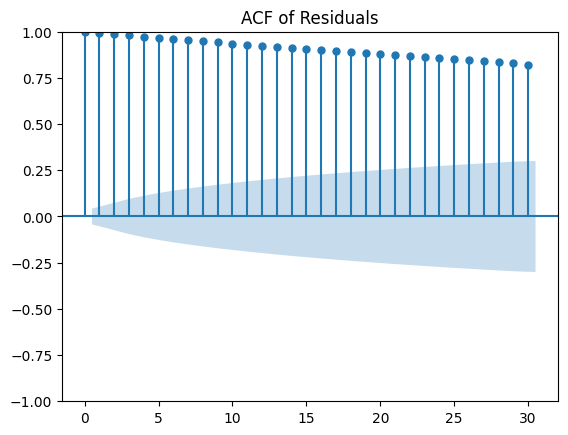

Text(0.5, 1.0, 'PACF of Residuals')

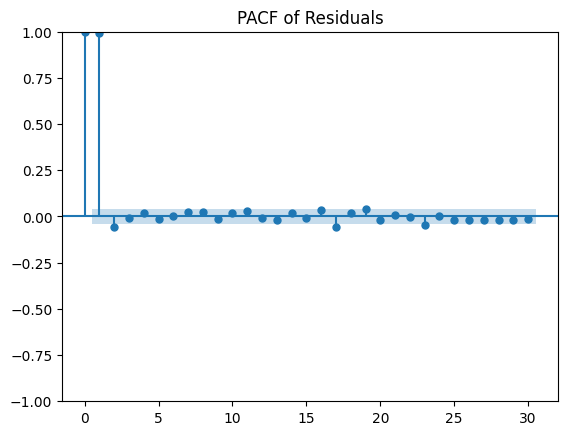

In [124]:
# test the acf and pacf of residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(residuals.dropna(), lags=30)
plt.title('ACF of Residuals')           
plt.show()
plot_pacf(residuals.dropna(), lags=30)
plt.title('PACF of Residuals')
# ------------------------

In [125]:
from statsmodels.tsa.ar_model import AutoReg

# Drop NaN values from residuals before fitting AR(1)
residuals_clean = residuals.dropna()

# Fit AR(1) on clean residuals
ar_model = AutoReg(residuals_clean, lags=1).fit()
phi = ar_model.params[1]  # AR(1) coefficient
sigma = np.std(ar_model.resid)  # std of innovation

print(f"Estimated phi (AR1): {phi:.4f}, sigma: {sigma:.4f}")


Estimated phi (AR1): 0.9943, sigma: 0.0049


#### Forecasting structural model 

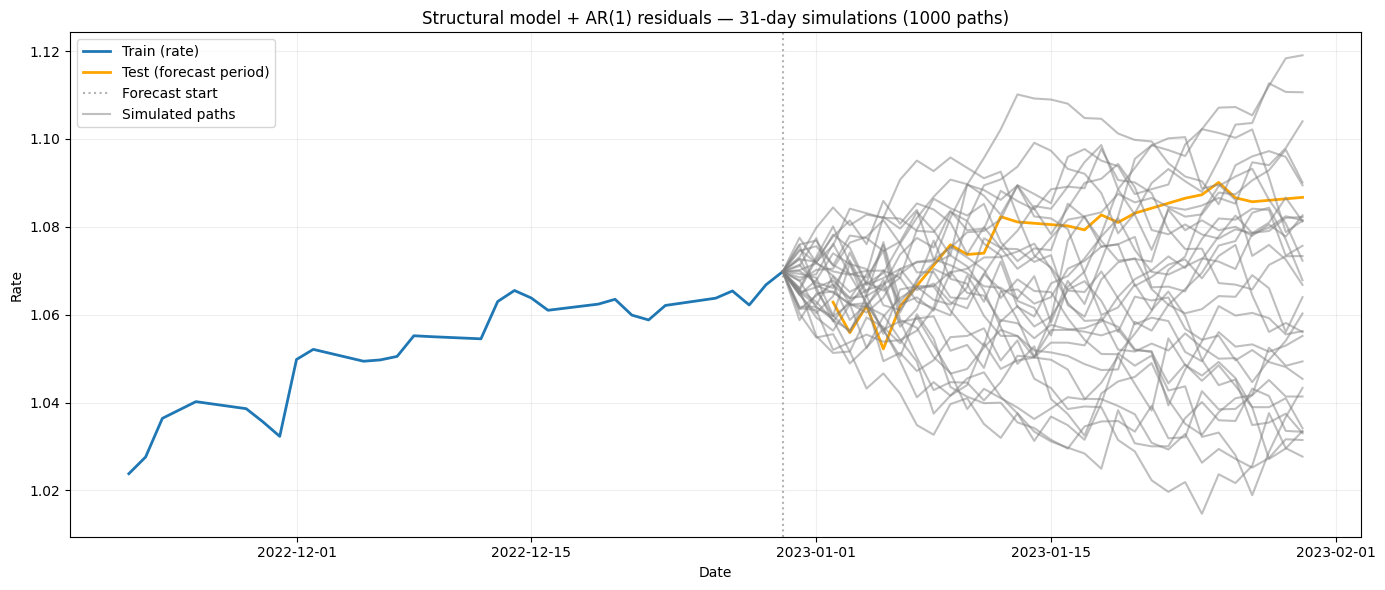

AR(1) params: {'phi': 0.9943272135908586, 'sigma': 0.004943102907961243}
Evaluated dates: 19
Evaluated paths: 1000 of 1000
✅ Expected RMSE (mean over paths): 0.020854
✅ Expected MAE  (mean over paths): 0.018225


In [127]:
# ------------------------
# 6) Prepare exog_future from REAL fundamentals (test window)
# ------------------------
steps = 31             # 1 month
n_sims = 1000          # number of simulation paths
start_fc = last_train_date + pd.Timedelta(days=1)
end_fc   = start_fc + pd.Timedelta(days=steps-1)

exog_future = df_all.loc[start_fc:end_fc, feature_cols].copy()
# exog_future = None # #  to use the last macroeconomic values without updating with future features

# ------------------------
# 7) Run your simulation & evaluation using the aligned df_all and exog_future
# ------------------------
from structural_model import simulate_structural_ar1_paths_and_plot, evaluate_structural_sims

all_paths, det_log, ar1_params = simulate_structural_ar1_paths_and_plot(
    model=model,
    residuals=residuals.loc[df_train.index],
    df=df_all,                     # OK: train + test
    steps=steps,
    n_sims=n_sims,
    n_show=30,
    rate_col=rate_col,
    log_rate_col=y_col,
    feature_cols=tuple(feature_cols),
    exog_future=exog_future,       # futuros reales en la ventana
    use_last_resid=True,
    seed=42,
    test_df=test_df,
    train_end_date=last_train_date # <-- clave: fija el fin de TRAIN
)

print("AR(1) params:", ar1_params)

# ------------------------
# 8) Evaluate against the test set
# ------------------------
metrics_structural = evaluate_structural_sims(
    all_paths=all_paths,
    test_df=test_df,
    rate_col='rate',        # use the column present in your test_df
    steps=steps,
    verbose=True
)
# Prepare the summary metrics
summary = append_result(
    summary,
    metrics={
        "expected_rmse": metrics_structural["expected_rmse"],
        "expected_mae":  metrics_structural["expected_mae"]
    },
    model_name="StructuralModel",
    horizon="1M"
)


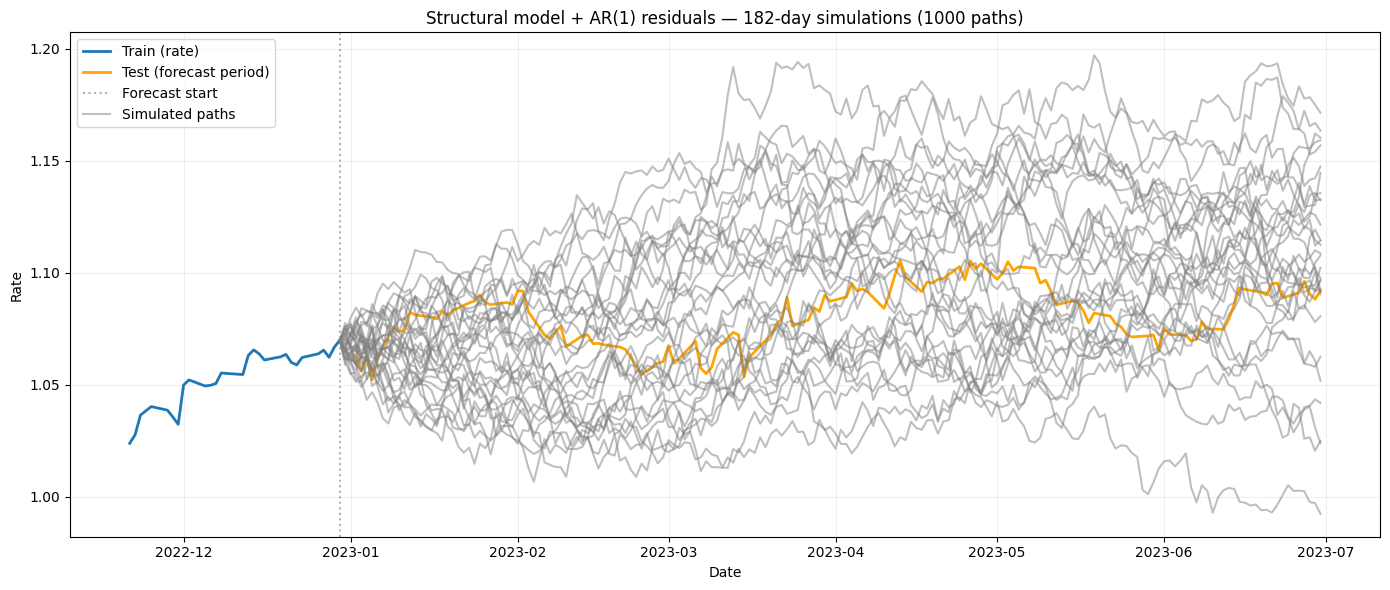

AR(1) params: {'phi': 0.9943272135908586, 'sigma': 0.004943102907961243}
Evaluated dates: 125
Evaluated paths: 1000 of 1000
✅ Expected RMSE (mean over paths): 0.040354
✅ Expected MAE  (mean over paths): 0.034310


In [128]:
# ------------------------
# 6) Prepare exog_future from REAL fundamentals (test window)
# ------------------------
steps = 182             # 6 month
n_sims = 1000          # number of simulation paths
start_fc = last_train_date + pd.Timedelta(days=1)
end_fc   = start_fc + pd.Timedelta(days=steps-1)

exog_future = df_all.loc[start_fc:end_fc, feature_cols].copy()
# exog_future = None # #  to use the last macroeconomic values without updating with future features

# ------------------------
# 7) Run your simulation & evaluation using the aligned df_all and exog_future
# ------------------------
from structural_model import simulate_structural_ar1_paths_and_plot, evaluate_structural_sims

all_paths, det_log, ar1_params = simulate_structural_ar1_paths_and_plot(
    model=model,
    residuals=residuals.loc[df_train.index],
    df=df_all,                     # OK: train + test
    steps=steps,
    n_sims=n_sims,
    n_show=30,
    rate_col=rate_col,
    log_rate_col=y_col,
    feature_cols=tuple(feature_cols),
    exog_future=exog_future,       # futuros reales en la ventana
    use_last_resid=True,
    seed=42,
    test_df=test_df,
    train_end_date=last_train_date # <-- clave: fija el fin de TRAIN
)

print("AR(1) params:", ar1_params)

# ------------------------
# 8) Evaluate against the test set
# ------------------------
metrics_structural = evaluate_structural_sims(
    all_paths=all_paths,
    test_df=test_df,
    rate_col='rate',        # use the column present in your test_df
    steps=steps,
    verbose=True
)
# Prepare the summary metrics
summary = append_result(
    summary,
    metrics={
        "expected_rmse": metrics_structural["expected_rmse"],
        "expected_mae":  metrics_structural["expected_mae"]
    },
    model_name="StructuralModel",
    horizon="6M"
)

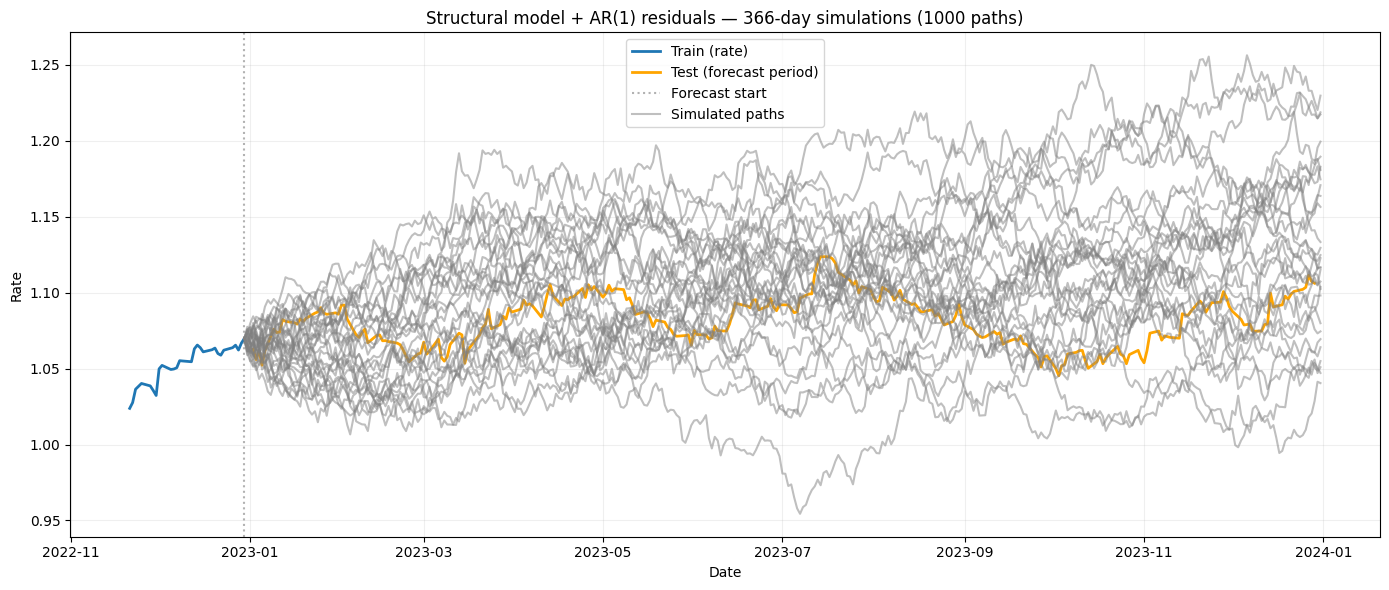

AR(1) params: {'phi': 0.9943272135908586, 'sigma': 0.004943102907961243}
Evaluated dates: 249
Evaluated paths: 1000 of 1000
✅ Expected RMSE (mean over paths): 0.052435
✅ Expected MAE  (mean over paths): 0.043681


In [129]:
# ------------------------
# 6) Prepare exog_future from REAL fundamentals (test window)
# ------------------------
steps = 366             # 12 month
n_sims = 1000          # number of simulation paths
start_fc = last_train_date + pd.Timedelta(days=1)
end_fc   = start_fc + pd.Timedelta(days=steps-1)

exog_future = df_all.loc[start_fc:end_fc, feature_cols].copy()
# exog_future = None # #  to use the last macroeconomic values without updating with future features

# ------------------------
# 7) Run your simulation & evaluation using the aligned df_all and exog_future
# ------------------------
from structural_model import simulate_structural_ar1_paths_and_plot, evaluate_structural_sims

all_paths, det_log, ar1_params = simulate_structural_ar1_paths_and_plot(
    model=model,
    residuals=residuals.loc[df_train.index],
    df=df_all,                     # OK: train + test
    steps=steps,
    n_sims=n_sims,
    n_show=30,
    rate_col=rate_col,
    log_rate_col=y_col,
    feature_cols=tuple(feature_cols),
    exog_future=exog_future,       # futuros reales en la ventana
    use_last_resid=True,
    seed=42,
    test_df=test_df,
    train_end_date=last_train_date # <-- clave: fija el fin de TRAIN
)

print("AR(1) params:", ar1_params)

# ------------------------
# 8) Evaluate against the test set
# ------------------------
metrics_structural = evaluate_structural_sims(
    all_paths=all_paths,
    test_df=test_df,
    rate_col='rate',        # use the column present in your test_df
    steps=steps,
    verbose=True
)
# Prepare the summary metrics
summary = append_result(
    summary,
    metrics={
        "expected_rmse": metrics_structural["expected_rmse"],
        "expected_mae":  metrics_structural["expected_mae"]
    },
    model_name="StructuralModel",
    horizon="12M"
)

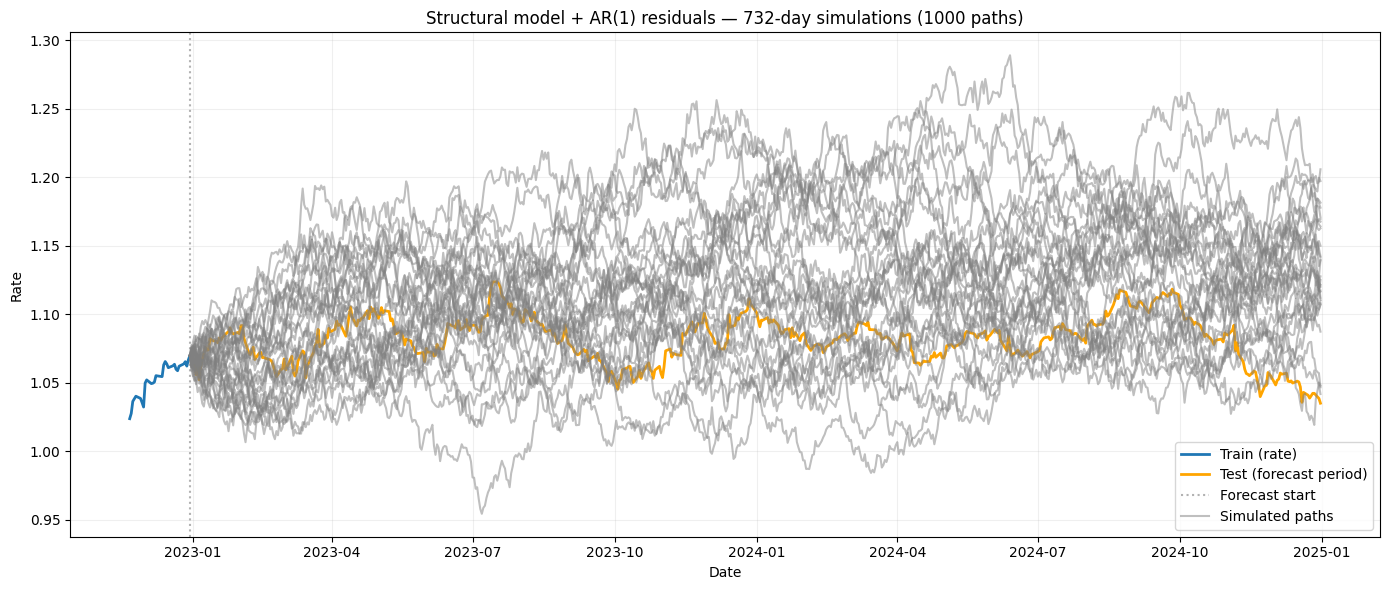

AR(1) params: {'phi': 0.9943272135908586, 'sigma': 0.004943102907961243}
Evaluated dates: 500
Evaluated paths: 1000 of 1000
✅ Expected RMSE (mean over paths): 0.061950
✅ Expected MAE  (mean over paths): 0.051418


In [130]:
# ------------------------
# 6) Prepare exog_future from REAL fundamentals (test window)
# ------------------------
steps = 366*2             # 6 month
n_sims = 1000          # number of simulation paths
start_fc = last_train_date + pd.Timedelta(days=1)
end_fc   = start_fc + pd.Timedelta(days=steps-1)

exog_future = df_all.loc[start_fc:end_fc, feature_cols].copy()
# exog_future = None # #  to use the last macroeconomic values without updating with future features

# ------------------------
# 7) Run your simulation & evaluation using the aligned df_all and exog_future
# ------------------------
from structural_model import simulate_structural_ar1_paths_and_plot, evaluate_structural_sims

all_paths, det_log, ar1_params = simulate_structural_ar1_paths_and_plot(
    model=model,
    residuals=residuals.loc[df_train.index],
    df=df_all,                     # OK: train + test
    steps=steps,
    n_sims=n_sims,
    n_show=30,
    rate_col=rate_col,
    log_rate_col=y_col,
    feature_cols=tuple(feature_cols),
    exog_future=exog_future,       # futuros reales en la ventana
    use_last_resid=True,
    seed=42,
    test_df=test_df,
    train_end_date=last_train_date # <-- clave: fija el fin de TRAIN
)

print("AR(1) params:", ar1_params)

# ------------------------
# 8) Evaluate against the test set
# ------------------------
metrics_structural = evaluate_structural_sims(
    all_paths=all_paths,
    test_df=test_df,
    rate_col='rate',        # use the column present in your test_df
    steps=steps,
    verbose=True
)
# Prepare the summary metrics
summary = append_result(
    summary,
    metrics={
        "expected_rmse": metrics_structural["expected_rmse"],
        "expected_mae":  metrics_structural["expected_mae"]
    },
    model_name="StructuralModel",
    horizon="24M"
)

In [131]:
summary

model horizon  expected_rmse  expected_mae
0        RandomWalk      1M       0.024741      0.021608
1        RandomWalk      6M       0.050992      0.043836
2        RandomWalk     12M       0.070192      0.060127
3        RandomWalk     24M       0.096621      0.083075
4             ARIMA      1M       0.022938      0.019976
5             ARIMA      6M       0.050245      0.043076
6             ARIMA     12M       0.068930      0.058591
7             ARIMA     24M       0.094618      0.080216
8   StructuralModel      1M       0.020854      0.018225
9   StructuralModel      6M       0.040354      0.034310
10  StructuralModel     12M       0.052435      0.043681
11  StructuralModel     24M       0.061950      0.051418

### Structural model + AR+ GARCH

In [132]:
# Structural model (OLS)
# log_rate = β0 + β1 * m_diff + β2 * y_diff + β3 * r_diff + u

# AR(1) for residuals
# u_t =const + ρ u_t−1 + ε_t

# GARCH(1,1) model for ε_t   --> Autoregressive Conditional Heteroskedasticity
# ε_t = σ_t * z_t 
# where z_t ~ N(0,1)
# 𝜎_𝑡 ^2 = 𝜔 + 𝛼 * 𝜀_𝑡−1 ^2 + 𝛽 * 𝜎_𝑡−1 ^2 ​



In [133]:
# eval heteroskedasticity of ε_t using ARCH-LM test
# the variance of errors is not constant, but changes over time depending on its own past.

from statsmodels.stats.diagnostic import het_arch

# ---------- AR(1) to residuals  ----------
residuals = pd.to_numeric(pd.Series(residuals), errors='coerce').dropna()

ar1 = AutoReg(residuals, lags=1, old_names=False).fit()
phi = ar1.params[1]
sigma = float(np.std(ar1.resid, ddof=1))
ar1_params = {'phi': float(phi), 'sigma': float(sigma)}

# eval ε_t after structural + ar(1)
eps = ar1.resid.dropna()        # <--  ε_t
stat, pval, _, _ = het_arch(eps, nlags=10)
print(f"ARCH-LM p-value: {pval:.4f}")

ARCH-LM p-value: 0.0000


c:\Users\luish\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


AR(1) params: {'phi': 0.9943272135908586, 'const': -5.356894166901158e-05}
GARCH(1,1) params: {'omega': 4.884508332549091e-07, 'alpha': 0.05, 'beta': 0.9299999999999999}
Volatility persistence (alpha+beta): 0.9800


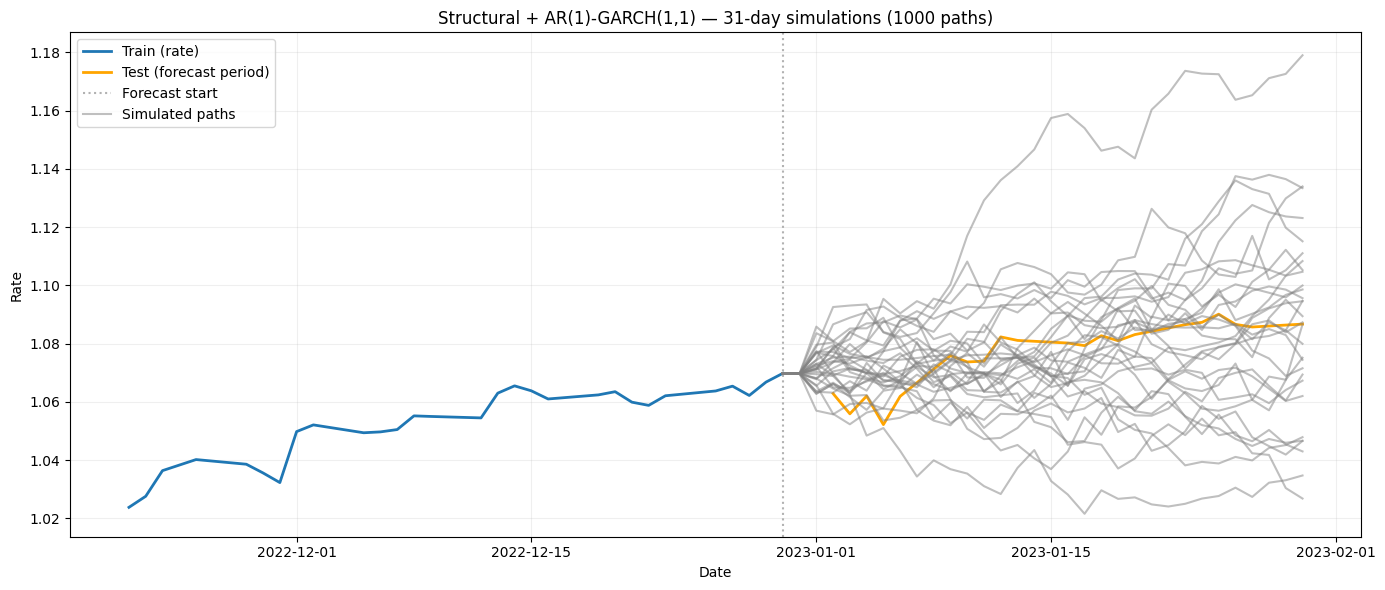

AR(1) params: {'phi': 0.9943272135908586, 'const': -5.356894166901158e-05}
GARCH(1,1) params: {'omega': 4.884508332549091e-07, 'alpha': 0.05, 'beta': 0.9299999999999999}
Evaluated dates: 19
Evaluated paths: 1000 of 1000
✅ Expected RMSE (mean over paths): 0.020118
✅ Expected MAE  (mean over paths): 0.017540


In [134]:
# ------------------------
# 6) Prepare exog_future from REAL fundamentals (test window)
# ------------------------
steps = 31
n_sims = 1000
start_fc = last_train_date + pd.Timedelta(days=1)
end_fc   = start_fc + pd.Timedelta(days=steps-1)

exog_future = df_all.loc[start_fc:end_fc, feature_cols].copy()
# exog_future = None  # to keep last macro values constant

# ------------------------
# 7) Run simulation & evaluation (AR(1)+GARCH)
# ------------------------
from structural_ar_garch_model import (
    simulate_structural_ar1_garch_paths_and_plot,
    evaluate_structural_sims_basic
)

all_paths, det_log, ar1_params, garch_params = simulate_structural_ar1_garch_paths_and_plot(
    model=model,
    residuals=residuals.loc[df_train.index],
    df=df_all,
    steps=steps,
    n_sims=n_sims,
    n_show=30,
    rate_col=rate_col,
    log_rate_col=y_col,
    feature_cols=tuple(feature_cols),
    exog_future=exog_future,
    use_last_resid=True,
    seed=42,
    test_df=test_df,
    train_end_date=last_train_date,
    dist='normal'  # or 't' if you want fat tails
)

print("AR(1) params:", ar1_params)
print("GARCH(1,1) params:", garch_params)

# ------------------------
# 8) Evaluate against the test set
# ------------------------
metrics_structural_garch = evaluate_structural_sims_basic(
    all_paths=all_paths,
    test_df=test_df,
    rate_col='rate',
    steps=steps,
    verbose=True
)

# Append to summary
summary = append_result(
    summary,
    metrics={
        "expected_rmse": metrics_structural_garch["expected_rmse"],
        "expected_mae":  metrics_structural_garch["expected_mae"]
    },
    model_name="Structural+AR(1)+GARCH",
    horizon="1M"
)


c:\Users\luish\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


AR(1) params: {'phi': 0.9943272135908586, 'const': -5.356894166901158e-05}
GARCH(1,1) params: {'omega': 4.884508332549091e-07, 'alpha': 0.05, 'beta': 0.9299999999999999}
Volatility persistence (alpha+beta): 0.9800


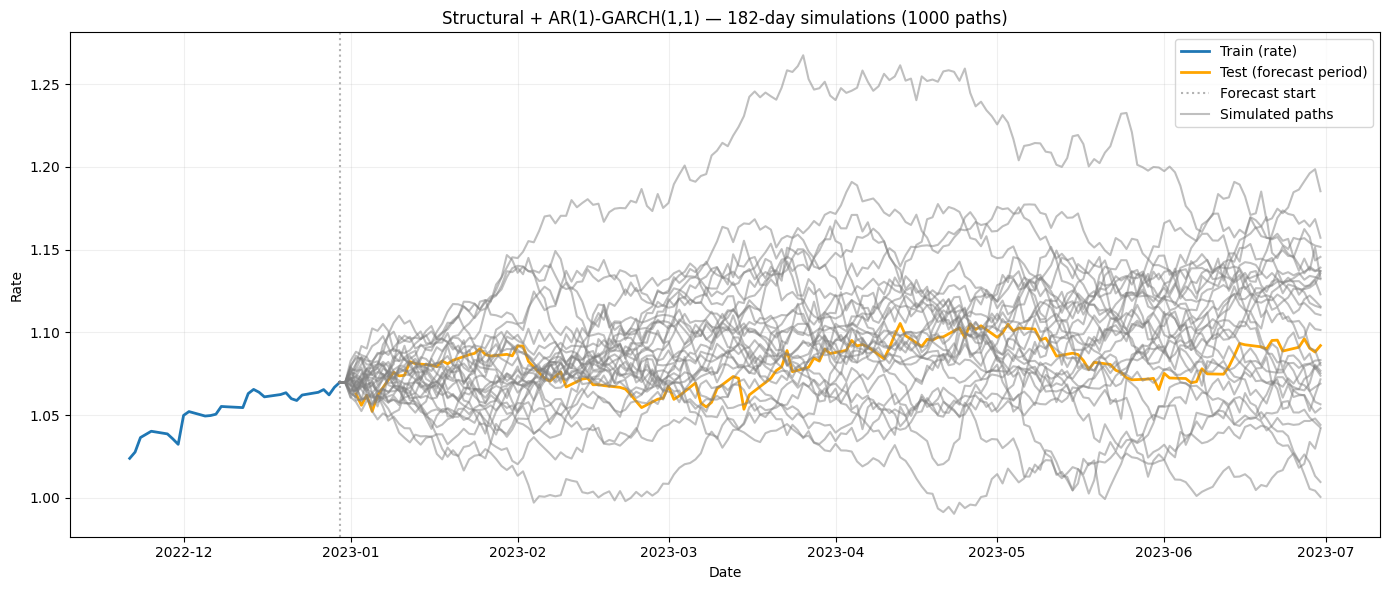

AR(1) params: {'phi': 0.9943272135908586, 'const': -5.356894166901158e-05}
GARCH(1,1) params: {'omega': 4.884508332549091e-07, 'alpha': 0.05, 'beta': 0.9299999999999999}
Evaluated dates: 125
Evaluated paths: 1000 of 1000
✅ Expected RMSE (mean over paths): 0.037773
✅ Expected MAE  (mean over paths): 0.031829


In [135]:
# ------------------------
# 6) Prepare exog_future from REAL fundamentals (test window)
# ------------------------
steps = 182
n_sims = 1000
start_fc = last_train_date + pd.Timedelta(days=1)
end_fc   = start_fc + pd.Timedelta(days=steps-1)

exog_future = df_all.loc[start_fc:end_fc, feature_cols].copy()
# exog_future = None  # to keep last macro values constant

# ------------------------
# 7) Run simulation & evaluation (AR(1)+GARCH)
# ------------------------
from structural_ar_garch_model import (
    simulate_structural_ar1_garch_paths_and_plot,
    evaluate_structural_sims_basic
)

all_paths, det_log, ar1_params, garch_params = simulate_structural_ar1_garch_paths_and_plot(
    model=model,
    residuals=residuals.loc[df_train.index],
    df=df_all,
    steps=steps,
    n_sims=n_sims,
    n_show=30,
    rate_col=rate_col,
    log_rate_col=y_col,
    feature_cols=tuple(feature_cols),
    exog_future=exog_future,
    use_last_resid=True,
    seed=42,
    test_df=test_df,
    train_end_date=last_train_date,
    dist='normal'  # or 't' if you want fat tails
)

print("AR(1) params:", ar1_params)
print("GARCH(1,1) params:", garch_params)

# ------------------------
# 8) Evaluate against the test set
# ------------------------
metrics_structural_garch = evaluate_structural_sims_basic(
    all_paths=all_paths,
    test_df=test_df,
    rate_col='rate',
    steps=steps,
    verbose=True
)

# Append to summary
summary = append_result(
    summary,
    metrics={
        "expected_rmse": metrics_structural_garch["expected_rmse"],
        "expected_mae":  metrics_structural_garch["expected_mae"]
    },
    model_name="Structural+AR(1)+GARCH",
    horizon="6M"
)


c:\Users\luish\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


AR(1) params: {'phi': 0.9943272135908586, 'const': -5.356894166901158e-05}
GARCH(1,1) params: {'omega': 4.884508332549091e-07, 'alpha': 0.05, 'beta': 0.9299999999999999}
Volatility persistence (alpha+beta): 0.9800


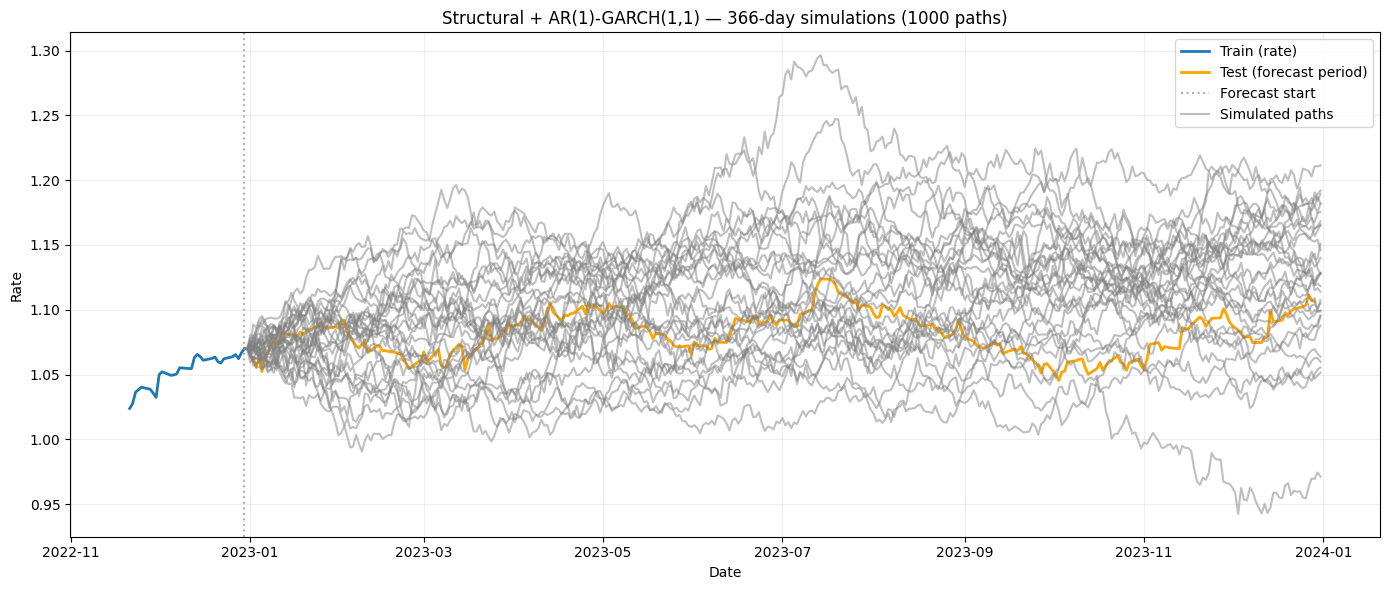

AR(1) params: {'phi': 0.9943272135908586, 'const': -5.356894166901158e-05}
GARCH(1,1) params: {'omega': 4.884508332549091e-07, 'alpha': 0.05, 'beta': 0.9299999999999999}
Evaluated dates: 249
Evaluated paths: 1000 of 1000
✅ Expected RMSE (mean over paths): 0.049168
✅ Expected MAE  (mean over paths): 0.040793


In [136]:
# ------------------------
# 6) Prepare exog_future from REAL fundamentals (test window)
# ------------------------
steps = 366
n_sims = 1000
start_fc = last_train_date + pd.Timedelta(days=1)
end_fc   = start_fc + pd.Timedelta(days=steps-1)

exog_future = df_all.loc[start_fc:end_fc, feature_cols].copy()
# exog_future = None  # to keep last macro values constant

# ------------------------
# 7) Run simulation & evaluation (AR(1)+GARCH)
# ------------------------
from structural_ar_garch_model import (
    simulate_structural_ar1_garch_paths_and_plot,
    evaluate_structural_sims_basic
)

all_paths, det_log, ar1_params, garch_params = simulate_structural_ar1_garch_paths_and_plot(
    model=model,
    residuals=residuals.loc[df_train.index],
    df=df_all,
    steps=steps,
    n_sims=n_sims,
    n_show=30,
    rate_col=rate_col,
    log_rate_col=y_col,
    feature_cols=tuple(feature_cols),
    exog_future=exog_future,
    use_last_resid=True,
    seed=42,
    test_df=test_df,
    train_end_date=last_train_date,
    dist='normal'  # or 't' if you want fat tails
)

print("AR(1) params:", ar1_params)
print("GARCH(1,1) params:", garch_params)

# ------------------------
# 8) Evaluate against the test set
# ------------------------
metrics_structural_garch = evaluate_structural_sims_basic(
    all_paths=all_paths,
    test_df=test_df,
    rate_col='rate',
    steps=steps,
    verbose=True
)

# Append to summary
summary = append_result(
    summary,
    metrics={
        "expected_rmse": metrics_structural_garch["expected_rmse"],
        "expected_mae":  metrics_structural_garch["expected_mae"]
    },
    model_name="Structural+AR(1)+GARCH",
    horizon="12M"
)


c:\Users\luish\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


AR(1) params: {'phi': 0.9943272135908586, 'const': -5.356894166901158e-05}
GARCH(1,1) params: {'omega': 4.884508332549091e-07, 'alpha': 0.05, 'beta': 0.9299999999999999}
Volatility persistence (alpha+beta): 0.9800


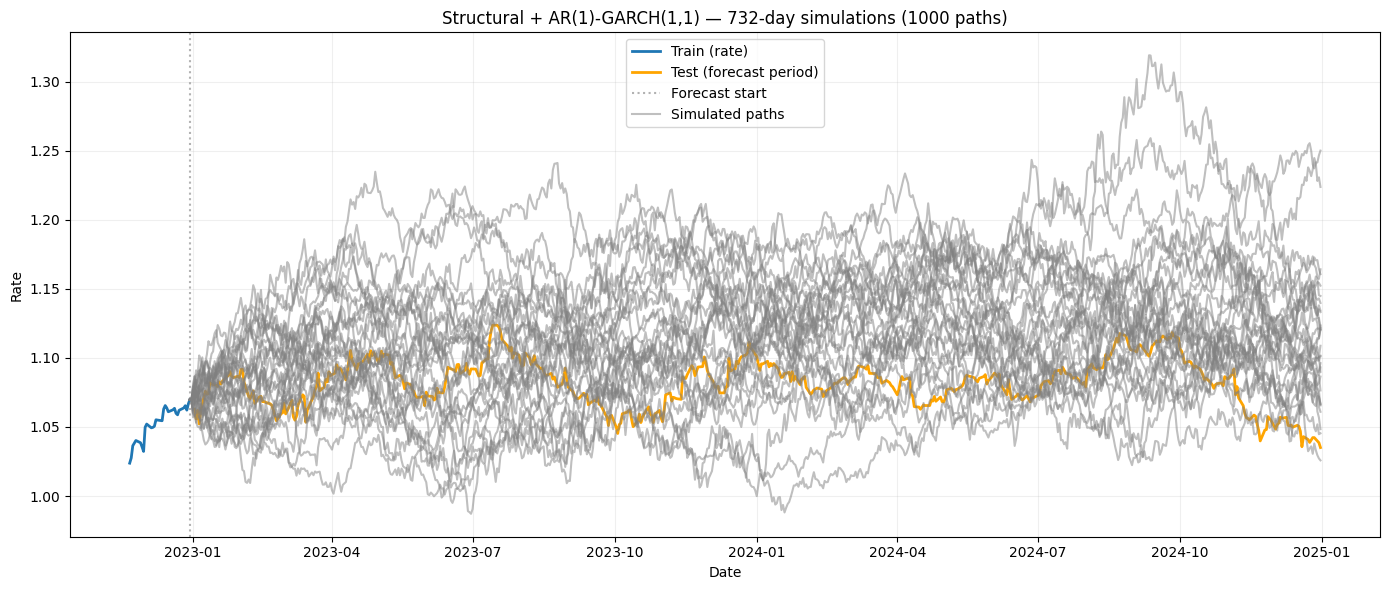

AR(1) params: {'phi': 0.9943272135908586, 'const': -5.356894166901158e-05}
GARCH(1,1) params: {'omega': 4.884508332549091e-07, 'alpha': 0.05, 'beta': 0.9299999999999999}
Evaluated dates: 500
Evaluated paths: 1000 of 1000
✅ Expected RMSE (mean over paths): 0.055978
✅ Expected MAE  (mean over paths): 0.046013


In [137]:
# ------------------------
# 6) Prepare exog_future from REAL fundamentals (test window)
# ------------------------
steps = 366*2
n_sims = 1000
start_fc = last_train_date + pd.Timedelta(days=1)
end_fc   = start_fc + pd.Timedelta(days=steps-1)

exog_future = df_all.loc[start_fc:end_fc, feature_cols].copy()
# exog_future = None  # to keep last macro values constant

# ------------------------
# 7) Run simulation & evaluation (AR(1)+GARCH)
# ------------------------
from structural_ar_garch_model import (
    simulate_structural_ar1_garch_paths_and_plot,
    evaluate_structural_sims_basic
)

all_paths, det_log, ar1_params, garch_params = simulate_structural_ar1_garch_paths_and_plot(
    model=model,
    residuals=residuals.loc[df_train.index],
    df=df_all,
    steps=steps,
    n_sims=n_sims,
    n_show=30,
    rate_col=rate_col,
    log_rate_col=y_col,
    feature_cols=tuple(feature_cols),
    exog_future=exog_future,
    use_last_resid=True,
    seed=42,
    test_df=test_df,
    train_end_date=last_train_date,
    dist='normal'  # or 't' if you want fat tails
)

print("AR(1) params:", ar1_params)
print("GARCH(1,1) params:", garch_params)

# ------------------------
# 8) Evaluate against the test set
# ------------------------
metrics_structural_garch = evaluate_structural_sims_basic(
    all_paths=all_paths,
    test_df=test_df,
    rate_col='rate',
    steps=steps,
    verbose=True
)

# Append to summary
summary = append_result(
    summary,
    metrics={
        "expected_rmse": metrics_structural_garch["expected_rmse"],
        "expected_mae":  metrics_structural_garch["expected_mae"]
    },
    model_name="Structural+AR(1)+GARCH",
    horizon="24M"
)


In [138]:
summary

model horizon  expected_rmse  expected_mae
0               RandomWalk      1M       0.024741      0.021608
1               RandomWalk      6M       0.050992      0.043836
2               RandomWalk     12M       0.070192      0.060127
3               RandomWalk     24M       0.096621      0.083075
4                    ARIMA      1M       0.022938      0.019976
5                    ARIMA      6M       0.050245      0.043076
6                    ARIMA     12M       0.068930      0.058591
7                    ARIMA     24M       0.094618      0.080216
8          StructuralModel      1M       0.020854      0.018225
9          StructuralModel      6M       0.040354      0.034310
10         StructuralModel     12M       0.052435      0.043681
11         StructuralModel     24M       0.061950      0.051418
12  Structural+AR(1)+GARCH      1M       0.020118      0.017540
13  Structural+AR(1)+GARCH      6M       0.037773      0.031829
14  Structural+AR(1)+GARCH     12M       0.049168      0.040793
15  Structural+AR(1)+GARCH     24M       0.055978      0.046013

## DEX US SF

In [139]:
# Read the CSV file from the preprocessing folder
train_df = pd.read_csv('../2. preprocesing/train_df_dexussf.csv', index_col=0, parse_dates=True)

# Show the first rows
train_df.head()

rate  rate_interpolated  log_rate      diff        Wt
date                                                                 
2015-01-05  0.085357           0.085357 -2.460913 -0.001409 -0.001226
2015-01-06  0.085466           0.085466 -2.459632  0.001281  0.001465
2015-01-07  0.085415           0.085415 -2.460230 -0.000598 -0.000415
2015-01-08  0.086558           0.086558 -2.446945  0.013285  0.013468
2015-01-09  0.087070           0.087070 -2.441042  0.005903  0.006087

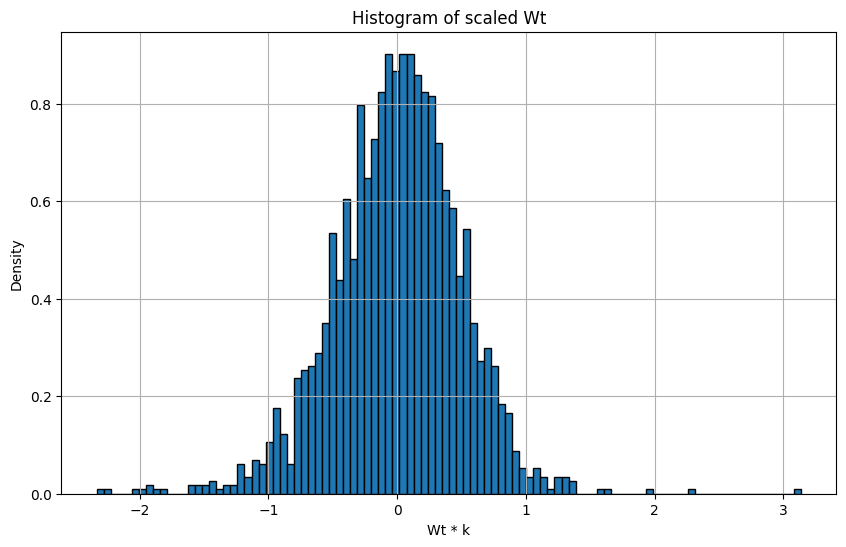

count    2085.000000
mean        0.000004
std         0.009860
min        -0.046718
25%        -0.005882
50%         0.000361
75%         0.006290
max         0.062758
Name: Wt, dtype: float64


In [140]:
k = 50
df= train_df.copy()
df['scaled_Wt'] = df['Wt'] * k
# basic histogram of the scaled Wt
plt.figure(figsize=(10,6))
plt.hist(df['scaled_Wt'], bins=100, edgecolor='black', density=True)
plt.title('Histogram of scaled Wt')
plt.xlabel('Wt * k')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# statistics of the original Wt
print(df['Wt'].describe())

Empirical probabilities:
P(-1) = 0.1405, P(0) = 0.7185, P(+1) = 0.1410


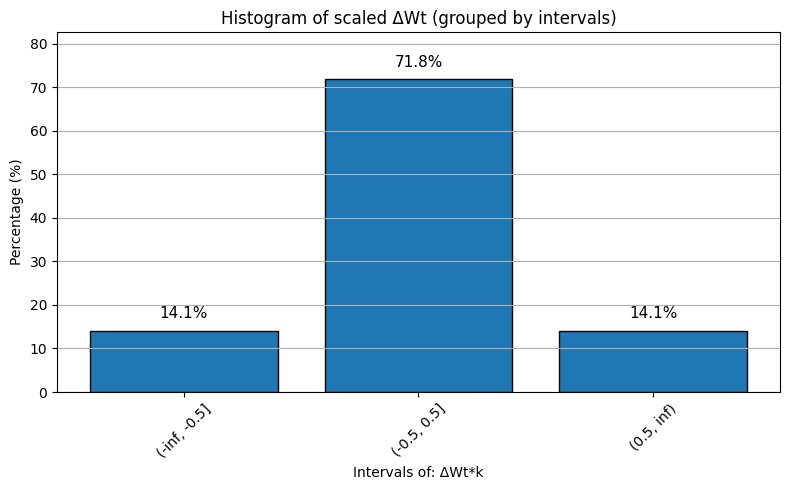

rate  rate_interpolated  log_rate      diff        Wt  \
date                                                                    
2015-01-05  0.085357           0.085357 -2.460913 -0.001409 -0.001226   
2015-01-06  0.085466           0.085466 -2.459632  0.001281  0.001465   
2015-01-07  0.085415           0.085415 -2.460230 -0.000598 -0.000415   
2015-01-08  0.086558           0.086558 -2.446945  0.013285  0.013468   
2015-01-09  0.087070           0.087070 -2.441042  0.005903  0.006087   
...              ...                ...       ...       ...       ...   
2022-12-26       NaN           0.058356 -2.841191 -0.009596 -0.009413   
2022-12-27  0.057793           0.057793 -2.850880 -0.009689 -0.009506   
2022-12-28  0.058428           0.058428 -2.839955  0.010925  0.011108   
2022-12-29  0.059207           0.059207 -2.826722  0.013234  0.013417   
2022-12-30  0.058841           0.058841 -2.832919 -0.006197 -0.006014   

            scaled_Wt  e_t scaled_Wt_bin  
date                                      
2015-01-05  -0.061291    0   (-0.5, 0.5]  
2015-01-06   0.073237    0   (-0.5, 0.5]  
2015-01-07  -0.020726    0   (-0.5, 0.5]  
2015-01-08   0.673404    1    (0.5, inf)  
2015-01-09   0.304344    0   (-0.5, 0.5]  
...               ...  ...           ...  
2022-12-26  -0.470635    0   (-0.5, 0.5]  
2022-12-27  -0.475284    0   (-0.5, 0.5]  
2022-12-28   0.555410    1    (0.5, inf)  
2022-12-29   0.670855    1    (0.5, inf)  
2022-12-30  -0.300694    0   (-0.5, 0.5]  

[2085 rows x 8 columns]

In [141]:
# Step 1: Discretise Wt and get probabilities
train_df_dexuseu, p_dict = discretise_Wt(train_df, k=k)

train_df_dexuseu

## DEX US PEN

In [ ]:
# Read the CSV file from the preprocessing folder
train_df = pd.read_csv('../2. preprocesing/train_df_usdpen.csv', index_col=0, parse_dates=True)

# Show the first rows
train_df.head()

rate  rate_interpolated  log_rate      diff        Wt
date                                                                 
2015-01-07  0.334784           0.334784 -1.094270 -0.001340 -0.001232
2015-01-08  0.334560           0.334560 -1.094939 -0.000669 -0.000562
2015-01-09  0.334896           0.334896 -1.093935  0.001004  0.001112
2015-01-12  0.334560           0.334560 -1.094939 -0.001004 -0.000896
2015-01-13  0.335008           0.335008 -1.093600  0.001339  0.001447

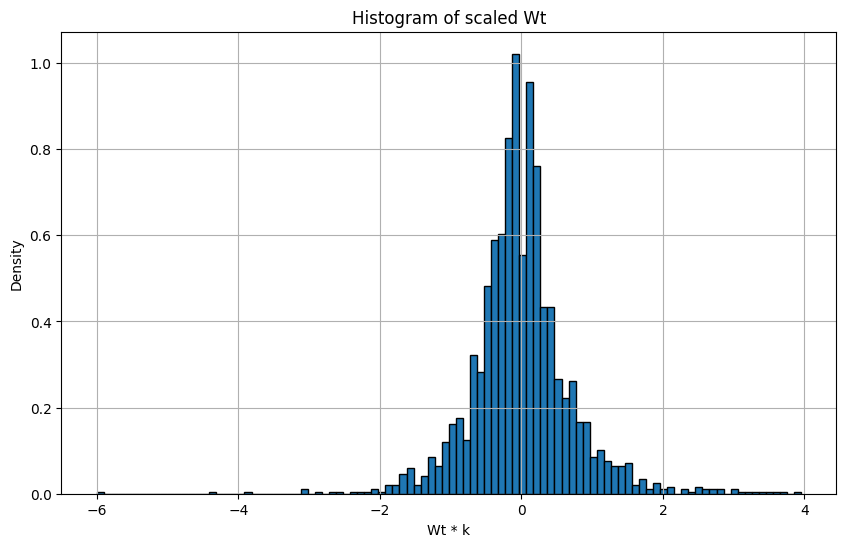

count    1996.000000
mean       -0.000016
std         0.003623
min        -0.030015
25%        -0.001727
50%        -0.000188
75%         0.001528
max         0.019757
Name: Wt, dtype: float64


In [ ]:
k = 200
df= train_df.copy()
df['scaled_Wt'] = df['Wt'] * k
# basic histogram of the scaled Wt
plt.figure(figsize=(10,6))
plt.hist(df['scaled_Wt'], bins=100, edgecolor='black', density=True)
plt.title('Histogram of scaled Wt')
plt.xlabel('Wt * k')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# statistics of the original Wt
print(df['Wt'].describe())

Empirical probabilities:
P(-1) = 0.1759, P(0) = 0.6603, P(+1) = 0.1638


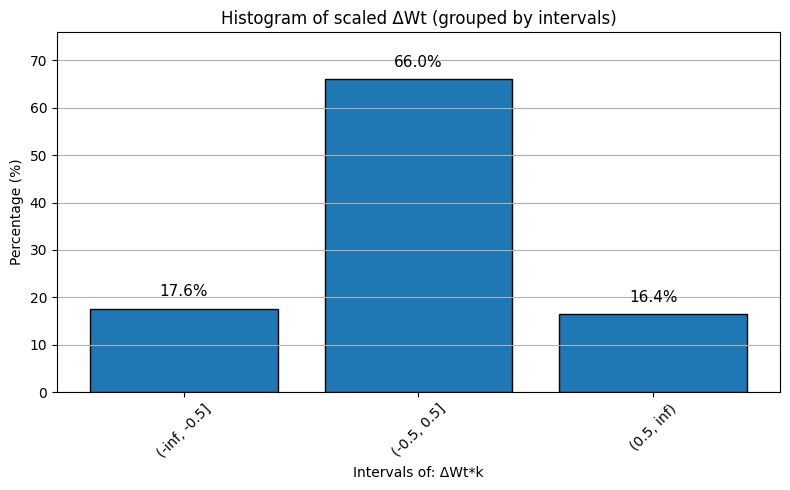

rate  rate_interpolated  log_rate      diff        Wt  \
date                                                                    
2015-01-07  0.334784           0.334784 -1.094270 -0.001340 -0.001232   
2015-01-08  0.334560           0.334560 -1.094939 -0.000669 -0.000562   
2015-01-09  0.334896           0.334896 -1.093935  0.001004  0.001112   
2015-01-12  0.334560           0.334560 -1.094939 -0.001004 -0.000896   
2015-01-13  0.335008           0.335008 -1.093600  0.001339  0.001447   
...              ...                ...       ...       ...       ...   
2022-12-26  0.261575           0.261575 -1.341035  0.001046  0.001154   
2022-12-27  0.261643           0.261643 -1.340774  0.000262  0.000369   
2022-12-28  0.261986           0.261986 -1.339465  0.001309  0.001417   
2022-12-29  0.261917           0.261917 -1.339727 -0.000262 -0.000154   
2022-12-30  0.261780           0.261780 -1.340250 -0.000524 -0.000416   

            scaled_Wt  e_t scaled_Wt_bin  
date                                      
2015-01-07  -0.246452    0   (-0.5, 0.5]  
2015-01-08  -0.112314    0   (-0.5, 0.5]  
2015-01-09   0.222392    0   (-0.5, 0.5]  
2015-01-12  -0.179282    0   (-0.5, 0.5]  
2015-01-13   0.289382    0   (-0.5, 0.5]  
...               ...  ...           ...  
2022-12-26   0.230705    0   (-0.5, 0.5]  
2022-12-27   0.073877    0   (-0.5, 0.5]  
2022-12-28   0.283369    0   (-0.5, 0.5]  
2022-12-29  -0.030835    0   (-0.5, 0.5]  
2022-12-30  -0.083184    0   (-0.5, 0.5]  

[1996 rows x 8 columns]

In [ ]:
# Step 1: Discretise Wt and get probabilities
train_df_dexuseu, p_dict = discretise_Wt(train_df, k=k)

train_df_dexuseu